In [1]:
!nvidia-smi

Sat Dec  9 15:03:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

載入Google Drive進入colab內


In [2]:
# 載入Google Drive進入colab內
from google.colab import drive
import os
drive.mount('/content/gdrive')

Mounted at /content/gdrive


更改目前路徑至Google雲端硬碟

In [3]:
import os
# # 更改目前路徑至Google雲端硬碟，mask-detector為程式資料夾名稱
os.chdir("/content/gdrive/My Drive/") #更改路徑
os.getcwd() #查看當前路徑

'/content/gdrive/My Drive'

In [4]:


!ls

 CLIP.ipynb
 CLIP.png
 CLIP_Test.ipynb
'Colab Notebooks'
'FeatherNets: Convolutional Neural Networks as Light as Feather for Face Anti-spoofing.gslides'
'Grey Modern Professional Business Project Presentation.pptx'
 moris-chinese-resume-sw.pdf
'Multi-Modal Face Anti-Spoofing Based on Central Difference Networks.gslides'
 test.pdf
'Traffic Sign Dataset'
 vaccine.pdf
 未命名簡報.gslides
'／獨家私藏／ 專業作詞曲祕技包.pdf'
'英文Z點鐘之黃金外商英文履歷模板與範例 的副本.gdoc'
 詹定璿_SW_2023.pdf
 隱
 黃小隻.JPG


In [5]:
%cd /content/gdrive/MyDrive/Traffic Sign Dataset

/content/gdrive/MyDrive/Traffic Sign Dataset


In [6]:
!conda install --yes -c pytorch pytorch=1.7.1 torchvision cudatoolkit=11.0
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

/bin/bash: line 1: conda: command not found
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 885.7 kB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-nr9hijho
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-nr9hijho
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369497 sha256=cf99c1f822e80b7decf1ed3a00626f1e6e0529b70a3bff0e623e5f92a221211e
  Stored in directory: /tmp/pip-ephem-wheel-cache-wq27oq1w/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [7]:
import os
current_path = os.getcwd()
print("当前工作目录：", current_path)

当前工作目录： /content/gdrive/MyDrive/Traffic Sign Dataset


In [10]:
import pandas as pd
import clip
df = pd.read_csv(os.path.join(current_path, "labels.csv"))
Name_list = list(df.Name)

In [11]:
df.Name.value_counts()[:3]

Bicycles crossing       2
Speed limit (40km/h)    2
Speed limit (50km/h)    2
Name: Name, dtype: int64

In [12]:
Un_unique_classes = list(df.Name.value_counts()[:3].keys())
df[df["Name"].isin(Un_unique_classes)]

,ClassId,Name
3,3,Speed limit (40km/h)
4,4,Speed limit (50km/h)
18,18,Speed limit (40km/h)
19,19,Speed limit (50km/h)
30,30,Bicycles crossing
36,36,Bicycles crossing


In [13]:
df[(df["Name"] == "Speed limit (40km/h)")]

,ClassId,Name
3,3,Speed limit (40km/h)
18,18,Speed limit (40km/h)


In [14]:
from torch.utils.data.dataset import Dataset
from glob import glob
from PIL import Image

class traffic_Dataset(Dataset):
    def __init__(self, root, split, transform):
        # --------------------------------------------
        # Initialize paths, transforms, and so on
        # --------------------------------------------
        self.transform = transform

        self.imgs = glob(f'{root}*/*')
        self.lbls = [int(os.path.basename(os.path.dirname(path))) for path in self.imgs]
        self.prompts = list(pd.read_csv(os.path.join(current_path, "labels.csv")).Name)
        assert len(self.imgs) == len(self.lbls), 'mismatched length!'
        print('Total data in {} split: {}'.format(split, len(self.imgs)))

        # Label from 0 to (len-1)
        # self.lbls = len(self.lbls)

    def __getitem__(self, index):
        # --------------------------------------------
        # 1. Read from file (using numpy.fromfile, PIL.Image.open)
        # 2. Preprocess the data (torchvision.Transform)
        # 3. Return the data (e.g. image and label)
        # --------------------------------------------
        imgpath = self.imgs[index]
        img = Image.open(imgpath).convert('RGB')
        lbl = int(self.lbls[index])
        prompt_text = "This is " + self.prompts[lbl]
        prompt = clip.tokenize(prompt_text)
        if self.transform is not None:
            img = self.transform(img)
        return img, lbl, prompt

    def __len__(self):
        # --------------------------------------------
        # Indicate the total size of the dataset
        # --------------------------------------------
        return len(self.imgs)

init_dataset = traffic_Dataset(root=current_path + '/traffic_Data/DATA/', split='All', transform=None)

class_names = Name_list

Total data in All split: 4170


In [15]:
import pandas as pd
import numpy as np
import tensorflow as tf
from PIL import Image
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import plotly.express as px
import random

In [16]:
inputBasePath = current_path
trainingFolder = 'traffic_Data/DATA'
testingFolder = 'traffic_Data/TEST'
classes = pd.read_csv(os.path.join(inputBasePath,'labels.csv'))
classes_size = len(classes)
print("Total number of classes: ", classes_size)

Total number of classes:  58


In [17]:
# 基本數據統計
num_samples = len(init_dataset)
print("Total number of samples: ", num_samples)
# num_classes = len(np.unique(init_dataset["label"]))

Total number of samples:  4170


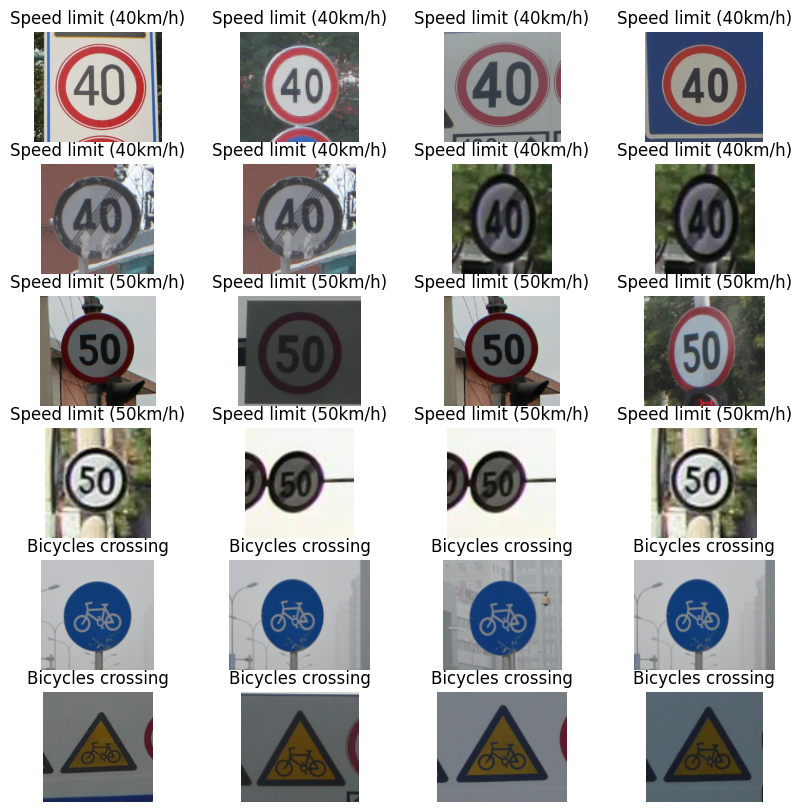

In [18]:
plt.figure(figsize=(10, 10))

avg_tok_len = []
labels_list = []
w_list = []
h_list = []

i_3 = 0
i_18 = 0

i_4 = 0
i_19 = 0

i_30 = 0
i_36 = 0

# subplot(row, column, index)
for i, (images, labels, prompt ) in enumerate(init_dataset):
  if labels == 3:
    if i_3 > 3: continue
    ax = plt.subplot(6, 4, i_3 + 1)
    plt.imshow(images)
    plt.title(class_names[labels])
    plt.axis("off")
    i_3 += 1
  if labels == 18:
    if i_18 > 3: continue
    ax = plt.subplot(6, 4, i_18 + 1 + 4)
    plt.imshow(images)
    plt.title(class_names[labels])
    plt.axis("off")
    i_18 += 1
  if labels == 4:
    if i_4 > 3: continue
    ax = plt.subplot(6, 4, i_4 + 1 + 8)
    plt.imshow(images)
    plt.title(class_names[labels])
    plt.axis("off")
    i_4 += 1
  if labels == 19:
    if i_19 > 3: continue
    ax = plt.subplot(6, 4, i_19 + 1 + 12)
    plt.imshow(images)
    plt.title(class_names[labels])
    plt.axis("off")
    i_19 += 1
  if labels == 30:
    if i_30 > 3: continue
    ax = plt.subplot(6, 4, i_30 + 1 + 16)
    plt.imshow(images)
    plt.title(class_names[labels])
    plt.axis("off")
    i_30 += 1
  if labels == 36:
    if i_36 > 3: continue
    ax = plt.subplot(6, 4, i_36 + 1 + 20)
    plt.imshow(images)
    plt.title(class_names[labels])
    plt.axis("off")
    i_36 += 1

plt.show()




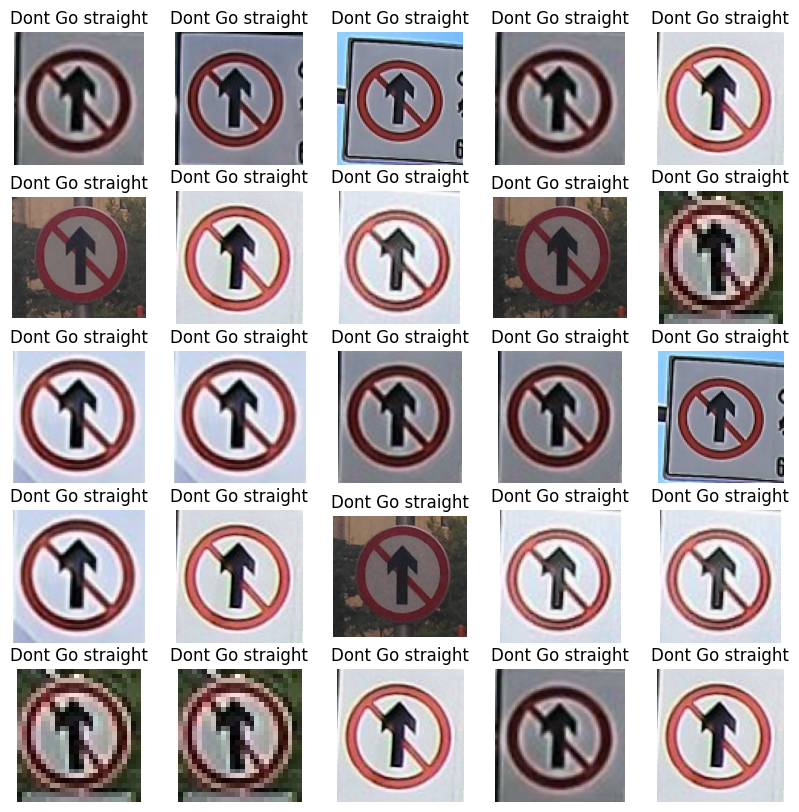

In [19]:
plt.figure(figsize=(10, 10))

avg_tok_len = []
labels_list = []
w_list = []
h_list = []

for i, (images, labels, prompt ) in enumerate(init_dataset):
  prompt = prompt[0]
  nonzero_indices = prompt.nonzero()
  # 從原始張量中提取非零元素
  nonzero_elements = prompt[nonzero_indices]
  tok_len = nonzero_elements.shape[0]
  avg_tok_len.append(tok_len)
  labels_list.append(labels)

  w_list.append(images.size[0])
  h_list.append(images.size[1])


  if i > 24: continue
  ax = plt.subplot(5, 5, i + 1)
  plt.imshow(images)
  plt.title(class_names[labels])
  plt.axis("off")

plt.show()


# 創建 DataFrame
df = pd.DataFrame({'Prompt_Labels': labels_list, 'Prompt_Tok_len': avg_tok_len})
df["Prompt_Text"] = [class_names[lbl] for lbl in labels_list]
df["Weight"] = w_list
df["Height"] = h_list

True     3518
False     652
Name: horizontal, dtype: int64

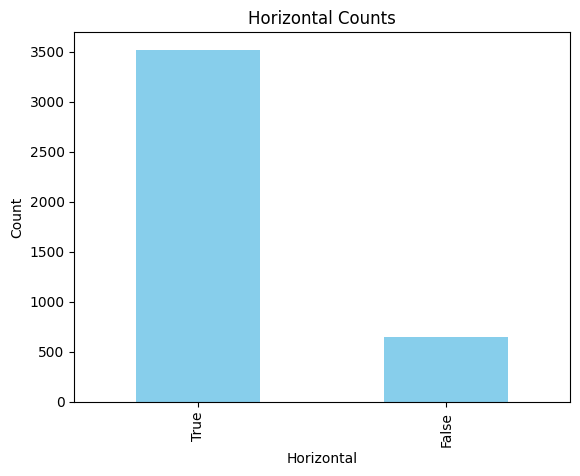

In [20]:
df = df.assign(horizontal=(df['Weight'] > df['Height']))
horizontal_value_counts = df.horizontal.value_counts()
horizontal_value_counts.plot(x='Horizontal', y='Count', kind='bar', color='skyblue')

# 添加標題和標籤
plt.title('Horizontal Counts')
plt.xlabel('Horizontal')
plt.ylabel('Count')
horizontal_value_counts

avg_tok_len: 8.25083932853717
max_tok_len: 13
min_tok_len: 5


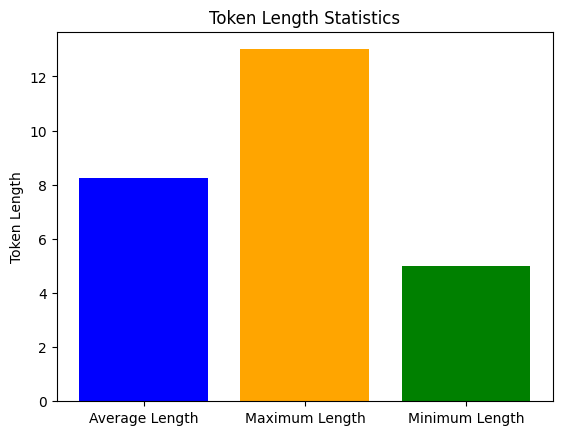

In [21]:
print(f"avg_tok_len: {sum(avg_tok_len)/len(avg_tok_len)}")
print(f"max_tok_len: {max(avg_tok_len)}")
print(f"min_tok_len: {min(avg_tok_len)}")

# Labels for the values
labels = ['Average Length', 'Maximum Length', 'Minimum Length']

# Values for the labels
values = [sum(avg_tok_len)/len(avg_tok_len), max(avg_tok_len), min(avg_tok_len)]

# Use Matplotlib to plot the bar chart
plt.bar(labels, values, color=['blue', 'orange', 'green'])

# Add title and y-axis label
plt.title('Token Length Statistics')
plt.ylabel('Token Length')

# Show the plot
plt.show()

In [22]:
category_counts = df['Prompt_Text'].value_counts()
sorted_counts_by_values  = category_counts.sort_values(ascending=False)

# 顯示排序後的結果
print("按照類別排序：")
# print(sorted_counts_by_index)
sorted_counts_by_values.head()



按照類別排序：


watch out for cars      446
No stopping             324
Speed limit (40km/h)    268
Speed limit (60km/h)    194
Bicycles crossing       190
Name: Prompt_Text, dtype: int64

Text(0, 0.5, 'Count')

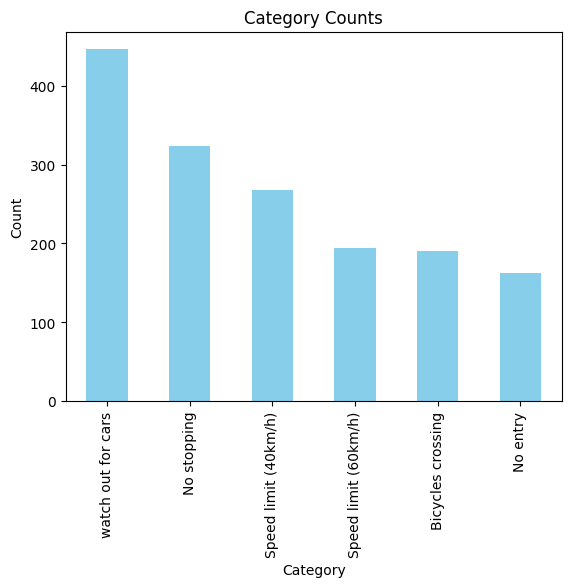

In [23]:
# 使用 plot() 函數繪製條形圖
top5h_sorted_counts_by_values = sorted_counts_by_values[:6]
top5h_sorted_counts_by_values.plot(x='Category', y='Count', kind='bar', color='skyblue')

# 添加標題和標籤
plt.title('Category Counts')
plt.xlabel('Category')
plt.ylabel('Count')

In [24]:
top5h_sorted_counts_by_values

watch out for cars      446
No stopping             324
Speed limit (40km/h)    268
Speed limit (60km/h)    194
Bicycles crossing       190
No entry                162
Name: Prompt_Text, dtype: int64

Text(0, 0.5, 'Count')

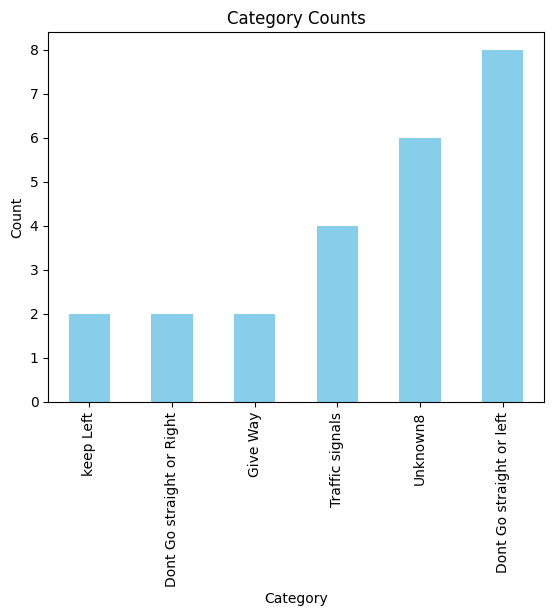

In [25]:
# 使用 plot() 函數繪製條形圖
uptop5h_sorted_counts_by_values = sorted_counts_by_values[len(sorted_counts_by_values)-6:]
uptop5h_sorted_counts_by_values  = uptop5h_sorted_counts_by_values.sort_values(ascending=True)
uptop5h_sorted_counts_by_values.plot(x='Category', y='Count', kind='bar', color='skyblue')

# 添加標題和標籤
plt.title('Category Counts')
plt.xlabel('Category')
plt.ylabel('Count')

In [26]:
uptop5h_sorted_counts_by_values

keep Left                    2
Dont Go straight or Right    2
Give Way                     2
Traffic signals              4
Unknown8                     6
Dont Go straight or left     8
Name: Prompt_Text, dtype: int64

In [27]:
df.describe()

,Prompt_Labels,Prompt_Tok_len,Weight,Height
count,4170.000000,4170.000000,4170.000000,4170.000000
mean,25.487770,8.250839,152.137170,140.856595
std,17.872244,2.828581,59.335121,52.668581
min,0.000000,5.000000,26.000000,28.000000
25%,10.000000,6.000000,109.000000,102.000000
50%,26.000000,7.000000,143.000000,132.000000
75%,38.000000,9.000000,182.000000,170.000000
max,57.000000,13.000000,491.000000,402.000000
